# Outline

- create a model that predicts the category of each article by `LogisticRegression`
- train data is `matichon.json` that contains about 16K articles of Thai news by Matichon between 2015-2018
- X is text of `headline` or `article`
- y is category (10 labels)
- use `DictVectorizer` so that we could add other features than tokens

# Import

In [1]:
import pandas as pd
import re, emoji, urllib, html

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

from pythainlp.tokenize import word_tokenize
from pythainlp.corpus import thai_stopwords

# Load data

- target variable is `category`
- `headline` and `article` are untokenized text

In [2]:
df = pd.read_json('data/matichon.json')
df

,headline,article,date,category,url,id
0,ซาอุฯจ่อเปิดไฟเขียวให้สิทธิหญิงม่าย-หย่าร้างปก...,(2 ธ.ค.58) หนังสือพิมพ์อัล ริยาดของทางการซาอุด...,2015-12-04 03:35:18,foreign,https://www.matichon.co.th/foreign/news_293,293
1,"""ไก่อู""ชี้ ตู่-เต้น ไม่ได้มีหน้าที่ตรวจสอบทุจร...","""บิ๊กป้อม"" แจง ครม. มีความพยายามยุยงปลุกปั่นให...",2015-12-04 04:10:49,politics,https://www.matichon.co.th/politics/news_329,329
2,"เปิดใจ ""โบว์ แวนดา"" ระหว่างรอยิ้มได้เต็มที่ในว...",แม้จะทำหน้าที่ภรรยาที่ดีมาเฝ้าปอ – ทฤษฎี สหวงษ...,2015-12-04 06:30:11,entertainment,https://www.matichon.co.th/entertainment/news_375,375
3,"""นาย ณภัทร"" ปลื้มคนชมแชมป์ขึ้นปกนิตยสารแห่งปี ...",กลายเป็นดาราหนุ่มเนื้อหอมแฟนคลับแน่น กระแสมาแร...,2015-12-04 07:10:26,entertainment,https://www.matichon.co.th/entertainment/news_393,393
4,"คอแทบหัก! แม่ยกแห่คล้องพวงมาลัยักษ์ ""บอย ศิริช...",แสดงดีจนเป็นที่ถูกอกถูกใจแฟนคลับ จนได้รับพวงมา...,2015-12-05 05:26:20,entertainment,https://www.matichon.co.th/entertainment/news_445,445
...,...,...,...,...,...,...
17104,โบว์ ณัฏฐา แจ้งความ พล.ต.อ.ศรีวราห์ ถูกพาดพิง...,เมื่อวันที่ 5 ก.ค. ที่ สน.พญาไท น.ส.ณัฏฐา มหัท...,2018-07-05 13:25:45,politics,https://www.matichon.co.th/politics/news_1029607,1029607
17105,ภาพบรรยากาศ ขุดทางระบายน้ำ เร่งนำ 13 ชีวิตออกจ...,วันที่ 5 กรกฎาคม เจ้าหน้าที่ขุดทางระบายน้ำที่ด...,2018-07-05 13:33:10,region,https://www.matichon.co.th/region/news_1029619,1029619
17106,สนช.ผ่านพ.ร.บ.สงฆ์ 3 วาระรวด พระมหากษัตริย์ทรง...,"สนช.ผ่าน พ.ร.บ.สงฆ์ 3 วาระรวด ""วิษณุ"" แจงสาระส...",2018-07-05 13:33:27,politics,https://www.matichon.co.th/politics/news_1029636,1029636
17107,นานาทรรศนะเพิ่มค่าปรับหมอ 5ล้านบ. สกัดเบี้ยว...,หมายเหตุ – จากกรณีที่ กระทรวงศึกษาธิการ (ศธ.) ...,2018-07-05 13:53:26,education,https://www.matichon.co.th/education/news_1029668,1029668


In [3]:
## drop "date", "url", and "id"
df.drop(columns=['date','url','id'], inplace=True)
df.head()

,headline,article,category
0,ซาอุฯจ่อเปิดไฟเขียวให้สิทธิหญิงม่าย-หย่าร้างปก...,(2 ธ.ค.58) หนังสือพิมพ์อัล ริยาดของทางการซาอุด...,foreign
1,"""ไก่อู""ชี้ ตู่-เต้น ไม่ได้มีหน้าที่ตรวจสอบทุจร...","""บิ๊กป้อม"" แจง ครม. มีความพยายามยุยงปลุกปั่นให...",politics
2,"เปิดใจ ""โบว์ แวนดา"" ระหว่างรอยิ้มได้เต็มที่ในว...",แม้จะทำหน้าที่ภรรยาที่ดีมาเฝ้าปอ – ทฤษฎี สหวงษ...,entertainment
3,"""นาย ณภัทร"" ปลื้มคนชมแชมป์ขึ้นปกนิตยสารแห่งปี ...",กลายเป็นดาราหนุ่มเนื้อหอมแฟนคลับแน่น กระแสมาแร...,entertainment
4,"คอแทบหัก! แม่ยกแห่คล้องพวงมาลัยักษ์ ""บอย ศิริช...",แสดงดีจนเป็นที่ถูกอกถูกใจแฟนคลับ จนได้รับพวงมา...,entertainment


In [4]:
## value counts of target variable
df.category.value_counts()

politics         3135
region           2655
crime            2141
local            1938
publicize        1481
foreign          1329
economy          1249
sport            1202
education        1053
entertainment     926
Name: category, dtype: int64

# Tokenize

- it may take more than a minute
- you can save the tokenized file by `df.to_json('XXX.json', orient='records')`

In [5]:
df['headline_tokens'] = df.headline.apply(word_tokenize)
df['article_tokens'] = df.article.apply(word_tokenize)

df.head()

,headline,article,category,headline_tokens,article_tokens
0,ซาอุฯจ่อเปิดไฟเขียวให้สิทธิหญิงม่าย-หย่าร้างปก...,(2 ธ.ค.58) หนังสือพิมพ์อัล ริยาดของทางการซาอุด...,foreign,"[ซาอุฯ, จ่อ, เปิดไฟเขียว, ให้, สิทธิ, หญิง, ม่...","[(, 2, , ธ.ค., 58, ), , หนังสือพิมพ์, อัล, ..."
1,"""ไก่อู""ชี้ ตู่-เต้น ไม่ได้มีหน้าที่ตรวจสอบทุจร...","""บิ๊กป้อม"" แจง ครม. มีความพยายามยุยงปลุกปั่นให...",politics,"["", ไก่อู, "", ชี้, , ตู่, -, เต้น, , ไม่, ได...","["", บิ๊ก, ป้อม, "", , แจง, , ครม., , มี, ควา..."
2,"เปิดใจ ""โบว์ แวนดา"" ระหว่างรอยิ้มได้เต็มที่ในว...",แม้จะทำหน้าที่ภรรยาที่ดีมาเฝ้าปอ – ทฤษฎี สหวงษ...,entertainment,"[เปิดใจ, , "", โบว์, , แวนดา, "", , ระหว่าง, ...","[แม้, จะ, ทำหน้าที่, ภรรยา, ที่, ดี, มา, เฝ้า,..."
3,"""นาย ณภัทร"" ปลื้มคนชมแชมป์ขึ้นปกนิตยสารแห่งปี ...",กลายเป็นดาราหนุ่มเนื้อหอมแฟนคลับแน่น กระแสมาแร...,entertainment,"["", นาย, , ณ, ภัทร, "", , ปลื้ม, คน, ชม, แชมป...","[กลายเป็น, ดารา, หนุ่ม, เนื้อ, หอม, แฟนคลับ, แ..."
4,"คอแทบหัก! แม่ยกแห่คล้องพวงมาลัยักษ์ ""บอย ศิริช...",แสดงดีจนเป็นที่ถูกอกถูกใจแฟนคลับ จนได้รับพวงมา...,entertainment,"[คอ, แทบ, หัก, !, , แม่ยก, แห่, คล้อง, พวงมาล...","[แสดง, ดี, จน, เป็นที่, ถูกอกถูกใจ, แฟนคลับ, ..."


# Feature Engineering


### featurize function
- input is tokenized sentence (list of str)
- output is feature dictionary `{feature: 1}` 
- bag-of-words, but **binary value** (not actual count, just existence)
- use *unigram only* or *unigram & bigram*
- use not only tokens, but also other features, e.g. text length

~~~python
['the','boy','love','the','dog'] 
-> {'TEXT_LENGTH':5, 'the':1, 'boy':1, 'love':1, 'dog':1, 'the|boy':1, 'boy|love':1, 'love|the':1, 'the|dog':1}
~~~

In [22]:
def featurize_unigram(tokens:list):
    feat_dic = {t:1 for t in set(tokens)}
    feat_dic['TEXT_LENGTH'] = len(tokens)
    return feat_dic

def featurize_bigram(tokens:list, ignore_words=[]):
    feat_dic = {}
    for i, token in enumerate(tokens):
        ## add unigram
        if token not in ignore_words:
            feat_dic[token] = 1
        ## add bigram
        if i < len(tokens) - 1:
            bigram = '|'.join(tokens[i:i+2]) # e.g. [ฉัน,ไป] -> ฉัน|ไป
            if bigram not in ignore_words:
                feat_dic[bigram] = 1
        ## add text length
        feat_dic['TEXT_LENGTH'] = len(tokens)
    return feat_dic


### create X and y

- X has 4 patterns : (headline, article) x (unigram, bigram)
- y is the same one

In [7]:
X_headline_unigram = df['headline_tokens'].apply(featurize_unigram)
X_headline_bigram = df['headline_tokens'].apply(featurize_bigram)
X_article_unigram = df['article_tokens'].apply(featurize_unigram)
X_article_bigram = df['article_tokens'].apply(featurize_bigram)

y = df['category']

### all-in-one function for training & prediction

In [8]:
def train_predict(X, show_confusion_matrix=False, return_model=True):
    ## train-test splitting
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    ## Instantiate DictVectorizer, LogisticRegression
    pipe = Pipeline([
        ('dv', DictVectorizer(sparse=True)),  ## feature dictionary -> vector
        ('logreg', LogisticRegression(max_iter=200, penalty='l2'))  # Ridge Regularization 
    ])

    pipe.fit(X_train, y_train) # train
    y_pred = pipe.predict(X_test) # predict
    class_name = pipe.named_steps['logreg'].classes_ # name of labels

    print(classification_report(y_test, y_pred))

    # print confusion matrix
    if show_confusion_matrix:
        cm = confusion_matrix(y_test, y_pred, labels=class_name)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_name)
        disp.plot(xticks_rotation=80)

    # return model
    if return_model:
        return pipe

# Model Comparison

### 1. use `headline` + unigram feature

In [9]:
model_head_uni = train_predict(X_headline_unigram)

               precision    recall  f1-score   support

        crime       0.64      0.64      0.64       428
      economy       0.70      0.62      0.66       250
    education       0.74      0.60      0.66       211
entertainment       0.82      0.83      0.82       185
      foreign       0.76      0.75      0.76       266
        local       0.38      0.40      0.39       388
     politics       0.79      0.83      0.81       627
    publicize       0.76      0.80      0.78       296
       region       0.59      0.58      0.58       531
        sport       0.84      0.88      0.86       240

     accuracy                           0.68      3422
    macro avg       0.70      0.69      0.70      3422
 weighted avg       0.68      0.68      0.68      3422



/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### 2. use `headline` + bigram feature

In [10]:
model_head_bi = train_predict(X_headline_bigram)

               precision    recall  f1-score   support

        crime       0.64      0.71      0.67       428
      economy       0.73      0.64      0.68       250
    education       0.71      0.64      0.68       211
entertainment       0.80      0.87      0.83       185
      foreign       0.80      0.74      0.77       266
        local       0.44      0.35      0.39       388
     politics       0.80      0.85      0.82       627
    publicize       0.78      0.83      0.80       296
       region       0.58      0.64      0.61       531
        sport       0.88      0.86      0.87       240

     accuracy                           0.70      3422
    macro avg       0.72      0.71      0.71      3422
 weighted avg       0.70      0.70      0.70      3422



/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### 3. use `article` + unigram feature

In [11]:
model_art_uni = train_predict(X_article_unigram)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


               precision    recall  f1-score   support

        crime       0.71      0.64      0.68       428
      economy       0.74      0.78      0.76       250
    education       0.79      0.81      0.80       211
entertainment       0.88      0.96      0.92       185
      foreign       0.96      0.89      0.93       266
        local       0.52      0.33      0.41       388
     politics       0.80      0.90      0.85       627
    publicize       0.79      0.87      0.83       296
       region       0.67      0.77      0.71       531
        sport       0.96      0.93      0.94       240

     accuracy                           0.77      3422
    macro avg       0.78      0.79      0.78      3422
 weighted avg       0.76      0.77      0.76      3422



### 4. use `article` + bigram feature
- it takes a few minutes to train

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


               precision    recall  f1-score   support

        crime       0.71      0.71      0.71       428
      economy       0.79      0.82      0.80       250
    education       0.86      0.84      0.85       211
entertainment       0.88      0.96      0.92       185
      foreign       0.95      0.95      0.95       266
        local       0.55      0.36      0.44       388
     politics       0.88      0.89      0.88       627
    publicize       0.84      0.88      0.86       296
       region       0.67      0.79      0.72       531
        sport       0.96      0.93      0.94       240

     accuracy                           0.79      3422
    macro avg       0.81      0.81      0.81      3422
 weighted avg       0.79      0.79      0.79      3422



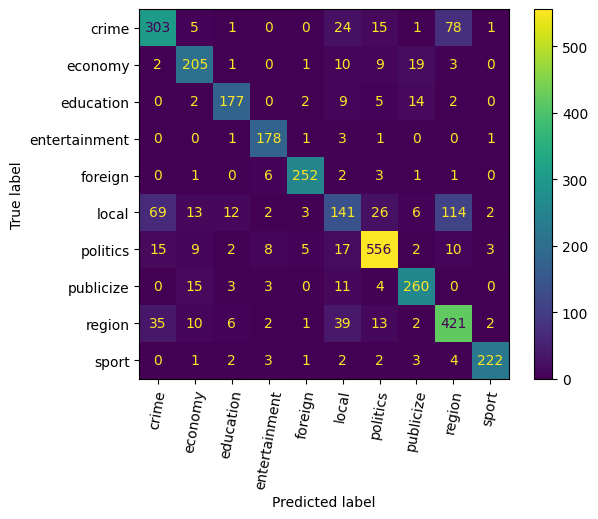

In [12]:
model_art_bi = train_predict(X_article_bigram, show_confusion_matrix=True)

- the score of the model using `article` and bigram feature is the best
- `local` is relatively low score (some are confused with `region`), while `sport` and `foreign` are very high 

# Coefficient of the model
- coefficients show "for which category, which words are important" 
- `model` is a pipeline of `DictVectorizer` and `LogisticRegression`
- feature names (vocabulary) are in `model.named_steps['dv'].get_feature_names_out()`
- coefficients are in `model.named_steps['logreg'].coef_`, which is (`number of class` * `number of features`) array
- class names are in `model.named_steps['logreg'].classes_`

In [13]:
logreg = model_art_bi.named_steps['logreg']
dv = model_art_bi.named_steps['dv']

coef_df = pd.DataFrame(logreg.coef_, index=logreg.classes_, columns=dv.get_feature_names_out())
coef_df

,\n,\n|,\n|,\n|,\n|,\n|,\n|,\n|,\n|,\n|,...,🤚🏻🤚🏻#|myanchan,🤣,🤣|\n,🤣|,🤣🤣🤣,🤣🤣🤣|,🤫,🤫|,🤬🤬🤬🤬,🤬🤬🤬🤬|เก่ง
crime,-0.083854,-0.021138,-0.024137,-0.011638,0.000850,0.000361,-0.001399,-0.006546,-0.000379,-0.006093,...,-0.000108,-0.000183,-0.000090,-0.000093,-0.000085,-0.000085,-0.000159,-0.000159,-0.000187,-0.000187
economy,0.044738,0.025729,0.114530,0.007085,-0.000496,-0.000730,-0.001021,-0.001502,-0.000259,-0.002966,...,-0.000115,-0.000145,-0.000112,-0.000033,-0.000074,-0.000074,-0.000136,-0.000136,-0.000095,-0.000095
education,-0.262812,-0.029981,-0.011328,-0.000962,-0.002826,-0.000889,-0.001513,-0.003795,-0.000525,-0.005889,...,-0.000122,-0.000241,-0.000175,-0.000066,-0.000084,-0.000084,-0.000161,-0.000161,-0.000121,-0.000121
entertainment,0.219242,0.020642,0.016160,0.012483,0.009771,0.008125,0.005900,-0.001704,0.001733,-0.002689,...,0.001206,0.002111,0.001370,0.000741,0.000870,0.000870,0.001806,0.001806,0.001484,0.001484
foreign,0.106175,-0.033960,-0.011914,-0.005760,-0.001825,-0.001368,-0.000925,-0.001430,-0.000426,-0.002940,...,-0.000142,-0.000097,-0.000082,-0.000015,-0.000096,-0.000096,-0.000267,-0.000267,-0.000225,-0.000225
local,-0.056520,0.057760,-0.013197,0.004447,-0.004637,-0.000578,-0.000854,-0.006789,-0.001524,-0.012619,...,-0.000142,-0.000318,-0.000223,-0.000094,-0.000124,-0.000124,-0.000218,-0.000218,-0.000221,-0.000221
politics,0.068578,-0.051051,-0.013210,-0.003507,-0.002623,-0.001477,-0.001339,0.000501,0.000637,0.004518,...,-0.000205,-0.000333,-0.000127,-0.000206,-0.000121,-0.000121,-0.000251,-0.000251,-0.000278,-0.000278
publicize,-0.112766,0.088335,-0.030982,0.004224,0.004675,0.000548,-0.000747,-0.001884,-0.000577,-0.003173,...,-0.000126,-0.000299,-0.000229,-0.000071,-0.000090,-0.000090,-0.000160,-0.000160,-0.000084,-0.000084
region,-0.019536,-0.057004,-0.015675,-0.003488,-0.001119,-0.002035,0.002867,0.025978,0.001633,0.035785,...,-0.000107,-0.000333,-0.000208,-0.000124,-0.000098,-0.000098,-0.000228,-0.000228,-0.000157,-0.000157
sport,0.096754,0.000668,-0.010246,-0.002883,-0.001770,-0.001958,-0.000968,-0.002830,-0.000313,-0.003933,...,-0.000138,-0.000163,-0.000124,-0.000039,-0.000099,-0.000099,-0.000226,-0.000226,-0.000116,-0.000116


In [14]:
## top 10 words for crime
## some are unigram feature
coef_df.loc['crime'].sort_values(ascending=False)[:10]

ตำรวจ          0.307522
คดี            0.298873
สอบสวน         0.245459
สน.            0.241884
วันที่         0.232136
เมื่อ|เวลา     0.227260
 |อายุ         0.226558
เจ้าหน้าที่    0.217786
ก.             0.215267
วันที่|        0.213736
Name: crime, dtype: float64

In [15]:
## top 10 words for sports
coef_df.loc['sport'].sort_values(ascending=False)[:10]

ทีม           0.601852
 |"           0.400029
กีฬา          0.376247
"|            0.354915
การแข่งขัน    0.354887
ทีม|ชาติ      0.328116
ศึก           0.326076
ฟุตบอล        0.324619
"             0.306353
เกม           0.297747
Name: sport, dtype: float64

# Error analysis - reduce misprediction

- find overlapping words and ignore
- e.g. between `local` and `region`

In [23]:
## intersection of top 200 words of `local` and `region`
overlapping_words = set(coef_df.loc['local'].sort_values(ascending=False)[:200].index) &\
        set(coef_df.loc['region'].sort_values(ascending=False)[:200].index)

overlapping_words

{' |กล่าวว่า',
 ' |จ.',
 ' |จากนั้น',
 ' |จึง',
 ' |ต.',
 ' |น.',
 ' |ผกก.',
 ' |มี',
 ' |รอง',
 ' |อ.',
 ' |อายุ',
 ' |เนื่องจาก',
 ' |โดยเฉพาะ',
 ' |ได้',
 'กล่าวว่า',
 'กล่าวว่า| ',
 'กว่า| ',
 'จ.',
 'จน',
 'จึง',
 'ชาวบ้าน',
 'ต.',
 'ตรวจสอบ',
 'ตำบล',
 'ทราบ|ว่า',
 'ทำให้',
 'น.',
 'น้ำ',
 'บริเวณ',
 'บ้าน',
 'ประชาชน',
 'ผู้สื่อข่าว',
 'พบ',
 'ภายใน',
 'รอง',
 'สภ.',
 'หมู่บ้าน',
 'อ.',
 'อายุ',
 'อายุ| ',
 'อำเภอ',
 'เกิด',
 'เขต',
 'เจ้าหน้าที่',
 'เนื่องจาก',
 'เมื่อ|เวลา',
 'เวลา| ',
 'โรงพยาบาล'}

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


               precision    recall  f1-score   support

        crime       0.66      0.70      0.68       428
      economy       0.81      0.82      0.82       250
    education       0.87      0.83      0.85       211
entertainment       0.91      0.96      0.94       185
      foreign       0.97      0.94      0.96       266
        local       0.48      0.44      0.46       388
     politics       0.85      0.90      0.87       627
    publicize       0.85      0.87      0.86       296
       region       0.70      0.66      0.68       531
        sport       0.97      0.93      0.95       240

     accuracy                           0.78      3422
    macro avg       0.81      0.81      0.81      3422
 weighted avg       0.78      0.78      0.78      3422



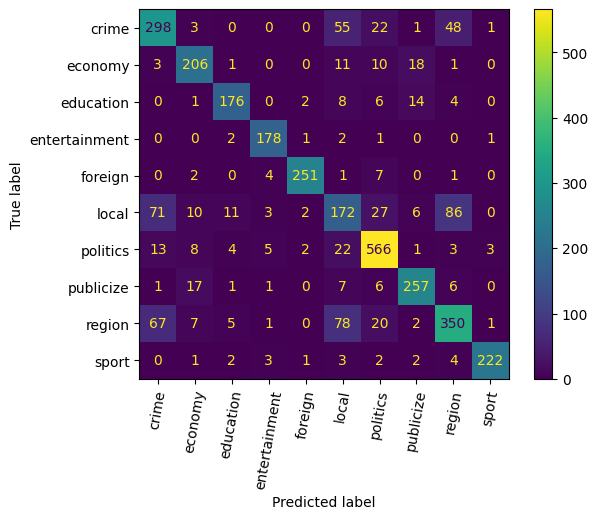

In [27]:
## make new X without overlapping words
X_article_bigram_ignored = df['article_tokens'].apply(lambda x: featurize_bigram(x, ignore_words=overlapping_words))

## train again
train_predict(X_article_bigram_ignored, show_confusion_matrix=True, return_model=False)


### model comparison

- after removing overlapping words, "actual local predicted as region" decreased
- but other mispredictions increased
- which is better - it depends on what you want

![cm_comparison](image/cm_comparison.png)

# If remove stopwords/punctuations?
- there are a lot of punctuation/stopwords in the result above
- clean data and tokenize again 
- allowed token pattern is `[A-zก-ไ][A-z0-9ก-๙\-\.]*`
- not use bigram, because many words are removed

In [16]:
STOPWORDS = thai_stopwords()

# example of cleaning
def clean_and_tokenize(text:str):
    ### REMOVE URL ###
    text = html.unescape(urllib.parse.unquote(text)) # unescape for unicode, unquote for escaped URL
    text = re.sub(r'https?.+?(?:\s|$)', '', text) # remove URL link
    ### REMOVE EMOJI ###
    text = emoji.replace_emoji(text) # remove emoji
    ### REPLACE TEXT ###
    text = re.sub(r'[“”„]', '"', text) # convert double quotations into "
    text = re.sub(r'[‘’′′′′`]', "'", text) # convert single quotations into '
    text = re.sub(r'[\n\t\u00a0\xa0\u3000\u2002-\u200a\u202f]+', ' ', text) # shrink whitespaces e.g. good  boy -> good boy
    text = re.sub(r'[\r\u200b\ufeff]+', '', text) # remove non-breaking space
    text = re.sub(r'[\u2028-\u202e]', '', text) # remove control puctuations 
    text = re.sub(r'เเ', 'แ', text)
    ### SHRINK SOME REDUPLICATION ###
    text = re.sub(r'าา+', 'า', text)
    text = re.sub(r'ยย+', 'ย', text)
    text = re.sub(r'ๆๆ+', 'ๆ', text)
    text = re.sub(r'ะะ+', 'ะ', text)
    ### am ###
    text = re.sub(r'ํา','ำ', text) # o + า -> ำ
    text = re.sub(r'\u0E33([\u0E48\u0E49\u0E4A\u0E4B])', r'\1'+'\u0E33', text) # am + tone -> tone + am
    ### TOKENIZE AND FILTERING ###
    tokens = word_tokenize(text.strip(), keep_whitespace=False)
    tokens = [token for token in tokens if re.match(r'[A-zก-ไ][A-z0-9ก-๙\-\.]*', token) and (token not in STOPWORDS)]
    return tokens

In [17]:
# clening, remove stopwords, unigram feature
X_article_unigram_cleaned = df['article'].apply(clean_and_tokenize).apply(featurize_unigram)
train_predict(X_article_unigram_cleaned, return_model=False)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


               precision    recall  f1-score   support

        crime       0.62      0.68      0.65       428
      economy       0.77      0.79      0.78       250
    education       0.77      0.81      0.79       211
entertainment       0.91      0.96      0.93       185
      foreign       0.93      0.93      0.93       266
        local       0.50      0.38      0.43       388
     politics       0.86      0.86      0.86       627
    publicize       0.82      0.82      0.82       296
       region       0.68      0.72      0.70       531
        sport       0.94      0.92      0.93       240

     accuracy                           0.76      3422
    macro avg       0.78      0.79      0.78      3422
 weighted avg       0.76      0.76      0.76      3422



- The result is almost the same as the previous uniigram model (3)
- Removing stopwords/punctuation did not help to improve the model in this case

# Result Summary 

||train data|feature|note|F1 macro score|
|--:|:-:|:-:|:-:|:-:|
|1|headline|unigram||0.70|
|2|headline|uni+bigram||0.71|
|3|article|unigram||0.79|
|4|article|uni+bigram||0.81|
|5|article|uni+bigram|remove overlapping words|0.81|
|6|article|unigram|remove stopwords|0.78|

# Further Improvement

- to change cleaning/tokenizing method may be less helpful
- tuning hyperparameters
- must modify featurize function
    - some category have specific characteristics except for tokens
    - e.g. `economy` may contain many digit characters -> try to use the feature such as `digit_char_ratio` 
- try other models e.g. Random Forest